# Image Denoising

We'll demonstrate the use of a typical encoder–decoder by denoising a very noisy brightfield image of a single particle.

## Simulate a Clean and Noisy Particle

We use `Deeptrack 2.0` to simulate a spherical particle.

In [1]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64,
    z=0,
    position_unit="pixel",
    radius=50e-8,
    refractive_index=1.45 + 0.02j,
)

2023-12-21 20:02:25.404263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We define the optical sysetm to image the particle.

In [2]:
brightfield_microscope = dt.Brightfield(
    wavelength=500e-9,
    NA=1,
    resolution=1e-6,
    magnification=10,
    refractive_index_medium=1.33,
    upsample=2,
    output_region=(0, 0, 64, 64),
)

We create the sample by applying the optical system to the particle.

In [3]:
illuminated_sample = brightfield_microscope(particle)

We create a workflow to simulate _clean_ particle images. We also corrupt them with some Poisson noise to have their _noisy_ version. We join the two workflows into a single simulation pipeline.

In [4]:
import torch

clean_particle = (
    illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand() * 1)
noisy_particle = (
    illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

pipeline = (noisy_particle) & (clean_particle)

We plot an example of the generated clean and noisy particle. 

For this, we write a simple function to plot the images and add it to `fnc_denoising.py`:

```python
import matplotlib.pyplot as plt


def plot_image(title, image):
    """Plot a grayscale image with a title."""
    
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.show()
```

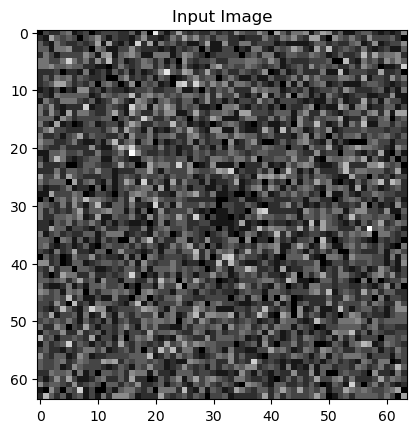

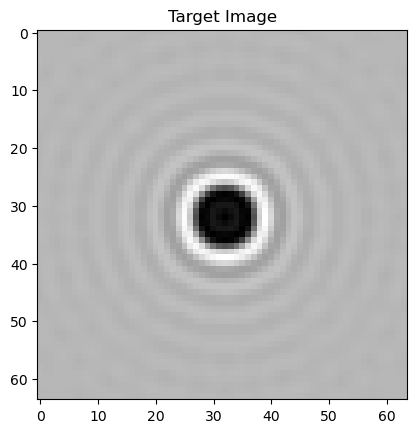

In [5]:
from fnc_denoising import plot_image

input, target = pipeline.update().resolve()

plot_image("Input Image", input.permute(1, 2, 0))
plot_image("Target Image", target.permute(1, 2, 0))

## Create a Dataset

We define a dataset class that uses the simulation pipeline to generate data. When calling the class, we establish the size of dataset but also introduce the possibility to replace some of the initial data on the fly. In this way we can increase the amount of data that the network sees during the whole training while we keep the dataset size fixed at each epoch, thus establishing a trade off between simulation/training time and generalization ability.

For this we'll create a class and add it to `fnc_denoising.py`:

```python
class SimulatedDataset(Dataset):
    """Simulated dataset generating pairs of noisy and clean images."""
    
    def __init__(self, pipeline, buffer_size, replace=0):
        self.buffer_size = buffer_size
        self.pipeline = pipeline
        self.replace = replace
        self.images = [pipeline.update().resolve() for _ in range(buffer_size)]

    def __len__(self):
        """Return the size of the dataset buffer."""
        
        return self.buffer_size

    def __getitem__(self, idx):
        """Retrieve a noisy-clean image pair from the dataset."""
        
        if np.random.rand() < self.replace:
            self.images[idx] = self.pipeline.update().resolve()
            
        image_pair = self.images[idx]
        noisy_image, clean_image = image_pair[0]._value, image_pair[1]._value
        
        return noisy_image, clean_image
```

We create the datasets and the data loaders. These will be used both for the training and for the testing, as each new image is never seen before.

In [6]:
from torch.utils.data import DataLoader
from fnc_denoising import SimulatedDataset

dataset = SimulatedDataset(pipeline, buffer_size=256, replace=0.2)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

## Define and Train the Autoencoder

We define the autoencoder architecture.

In [7]:
import deeplay as dl
from torch.nn import Sigmoid


autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[16, 16],
    decoder_channels=[16, 16],
    out_channels=1,
    out_activation=Sigmoid,
)

print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder_blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
    (1-2): 2 x PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
  )
  (bottleneck_blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Identity]()
      (activation): Layer[Identity]()
      (normalization): Layer[Identity]()
    )
  )
  (decoder_blocks): LayerList(
    (0-1): 2 x LayerActivationNormalizationUpsample(
      (layer): Layer[LazyConv2d](out_channels=16, kernel_size=

We define the loss and the optimizer...

In [8]:
import torchmetrics as tm
from torch.nn import L1Loss


regressor_template = dl.Regressor(
    model=autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)
autoencoder_regressor = regressor_template.create()

print(autoencoder_regressor)

Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): ConvolutionalEncoderDecoder2d(
    (encoder_blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (bottleneck_blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Identity()
        (activation): Identity()
        (normalization): Id

... and start the training.

In [9]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

autoencoder_trainer.fit(autoencoder_regressor, loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type                     

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


We visualize the autoencoder predictions.

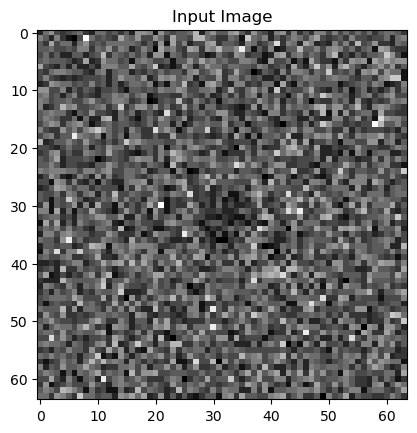

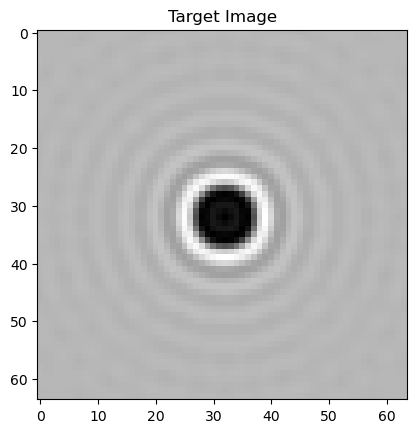

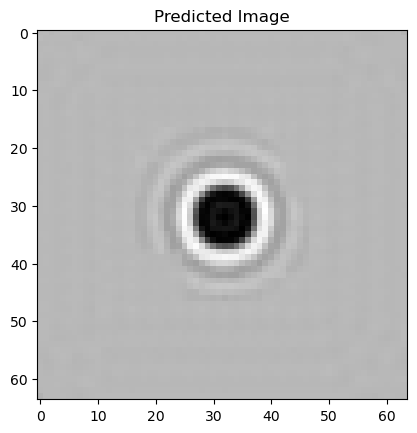

In [10]:
input, target = pipeline.update().resolve()
predicted = autoencoder_regressor(input.unsqueeze(0)).detach()

plot_image("Input Image", input[0, :, :])
plot_image("Target Image", target[0, :, :])
plot_image("Predicted Image", predicted[0, 0, :, :])

## Check the Absence of Mode Collapse

The training images are very similar. It can be that the autoencoder just learn to provide a centered particle, no matter what is the input (mode collapse). Let's check it out by making a prediction out of noise. 

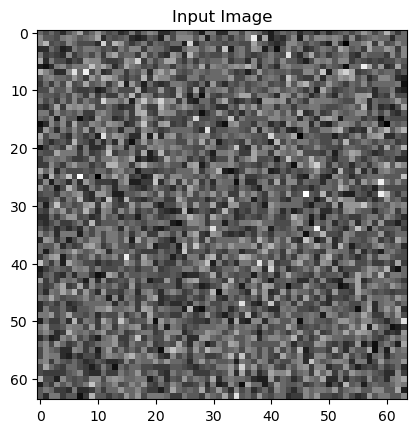

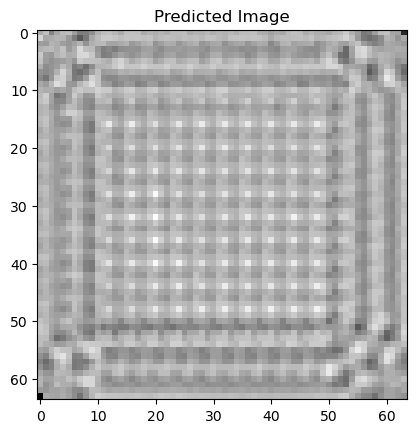

In [11]:
import torch

blank = brightfield_microscope(particle ^ 0)

blank_image = (
    blank
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

blank_image = blank_image.update().resolve()
blank_predicted = autoencoder_regressor(blank_image.unsqueeze(0)).detach()

plot_image("Input Image", blank_image[0, :, :])
plot_image("Predicted Image", np.square(blank_predicted[0, 0, :, :]))

## Check Generalization Capabilities

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

In [12]:
diverse_particle = dt.Sphere(
    position=lambda: np.array([0.2, 0.2] + np.random.rand(2) * 0.6) * 64, 
    z=0,
    position_unit="pixel",
    radius=lambda: 50e-8 + np.random.rand() * 50e-8,
    refractive_index=1.45 + 0.02j,
)

diverse_illuminated_sample = brightfield_microscope(diverse_particle)

diverse_clean_particle = (
    diverse_illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

diverse_noisy_particle = (
    diverse_illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

diverse_pipeline = (diverse_noisy_particle) & (diverse_clean_particle)

We check the predictions on this more challenging test set.

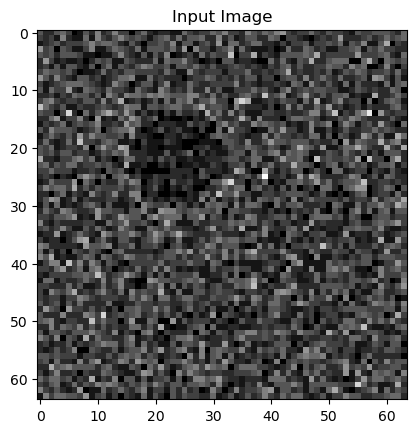

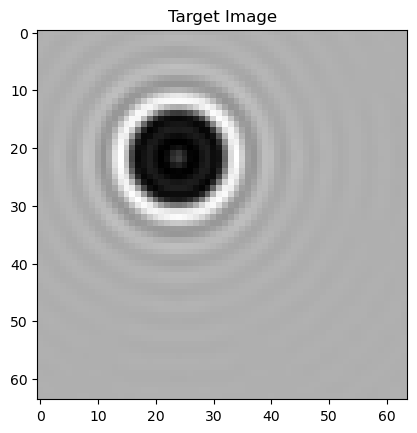

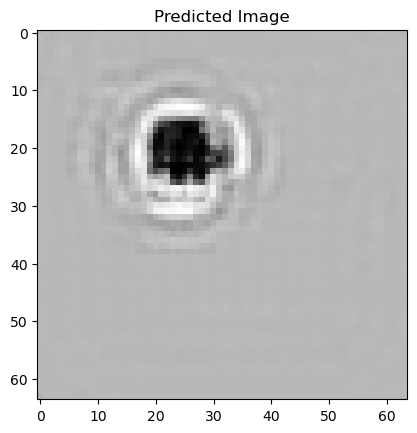

In [13]:
diverse_input, diverse_target = diverse_pipeline.update().resolve()
diverse_predicted = autoencoder_regressor(diverse_input.unsqueeze(0)).detach()
    
plot_image("Input Image", diverse_input[0, :, :])
plot_image("Target Image", diverse_target[0, :, :])
plot_image("Predicted Image", diverse_predicted[0, 0, :, :])

We can train on the new dataset.

In [14]:
diverse_dataset = SimulatedDataset(diverse_pipeline, buffer_size=256, 
                                   replace=0.2)
diverse_loader = DataLoader(diverse_dataset, batch_size=8, shuffle=True)
diverse_autoencoder_regressor = regressor_template.create()
diverse_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
diverse_autoencoder_trainer.fit(diverse_autoencoder_regressor, diverse_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 4.8 K 
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


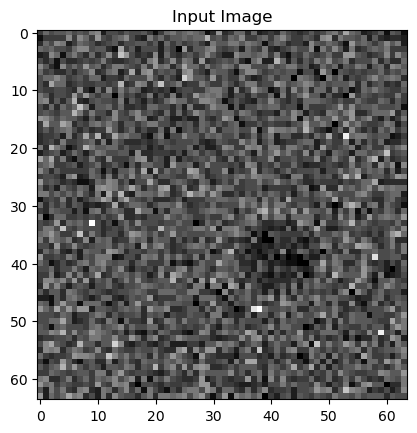

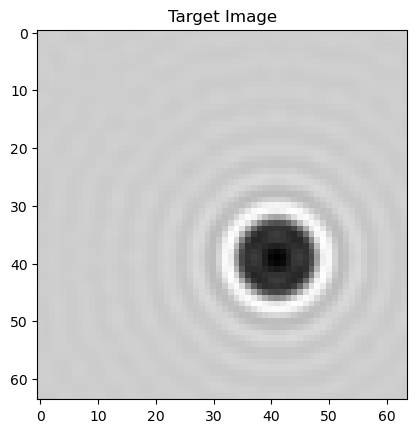

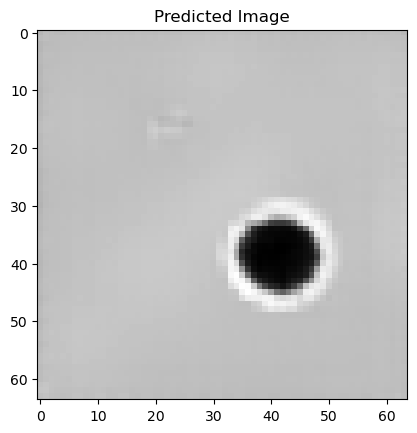

In [15]:
diverse_input, diverse_target = diverse_pipeline.update().resolve()
diverse_predicted = diverse_autoencoder_regressor(diverse_input.unsqueeze(0)).detach()
    
plot_image("Input Image", diverse_input[0, :, :])
plot_image("Target Image", diverse_target[0, :, :])
plot_image("Predicted Image", diverse_predicted[0, 0, :, :])

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [16]:
import deeplay as dl
from torch.nn import Sigmoid

better_autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 16, 32],
    decoder_channels=[32, 16, 8],
    out_channels=1,
    out_activation=Sigmoid,
)
print(better_autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder_blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=8)
    )
    (1): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
    (2): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=32)
    )
    (3): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Lay

In [17]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)
better_autoencoder_regressor = better_regressor_template.create()
better_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
better_autoencoder_trainer.fit(better_autoencoder_regressor, diverse_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 15.1 K
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


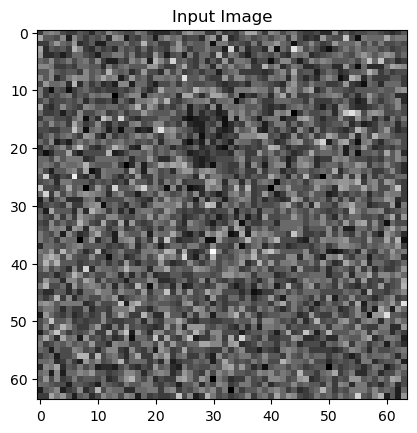

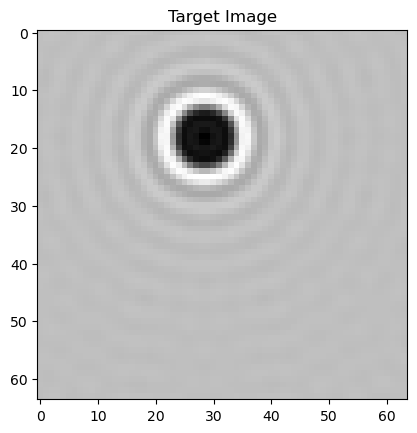

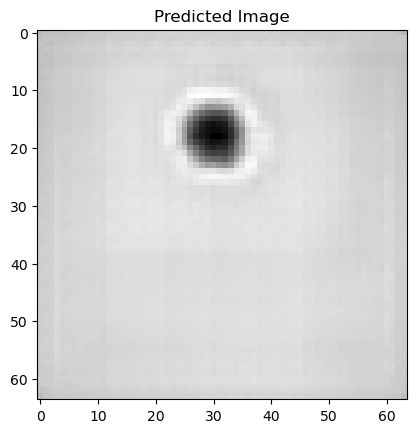

In [18]:
diverse_input, diverse_target = diverse_pipeline.update().resolve()
diverse_predicted = better_autoencoder_regressor(diverse_input.unsqueeze(0)).detach()
    
plot_image("Input Image", diverse_input[0, :, :])
plot_image("Target Image", diverse_target[0, :, :])
plot_image("Predicted Image", diverse_predicted[0, 0, :, :])